<center><h1>Linear Discriminants: logistic regression</h1></center>

$\renewcommand{\x}{\mathbf{x}}\renewcommand{\w}{\mathbf{w}}\renewcommand{\c}{\mathcal{C}}\renewcommand{\wx}{\w^\top\x}\newcommand{\class}{\c}$


|  Information  |  Your answer  |
|-----------|:---------------------------------|
| **Group** | *Report your group number here* |
| **Name 1** | *Fill in your names here* |
| **Name 2** | *Fill in your names here* |


# Some background

As we have seen in the lecture, the logistic regression models the probability of a class label $\c$ given a datapoint $p(\c|\x)$ as:
$$p(c|\x) = \sigma(\w^\top\x) = \frac{1}{1+e^{-\w^\top\x}}$$

In this lab, we shall implement this model.

## Logistic function

First, let us set things up; import the libraries we will need and define a function to plot heatmaps, to be used later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 5.0) # Set the size of future plots

import time
from IPython import display

xx,yy = np.mgrid[-5:10:.5,-5:10:.5]


def plotHeat(w):
    """ 
    Plot a weight vector w = [w_0,w_1,w_2] as a colour map
    """
    display.clear_output(wait=True)
    display.display(plt.gcf())
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = sigma(w.dot(np.array([1., xx[i,j], yy[i,j]])))
    plt.pcolor(xx,yy,p,cmap='seismic')
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.scatter(d[:,0],d[:,1],20,colours)
    time.sleep(.01)



To get started, let us plot the logistic function $\sigma(a)$ in the range $[-5\dots 5]$ in blue, and its derivative $\frac{\partial}{\partial a} \sigma(a)$ in green. 

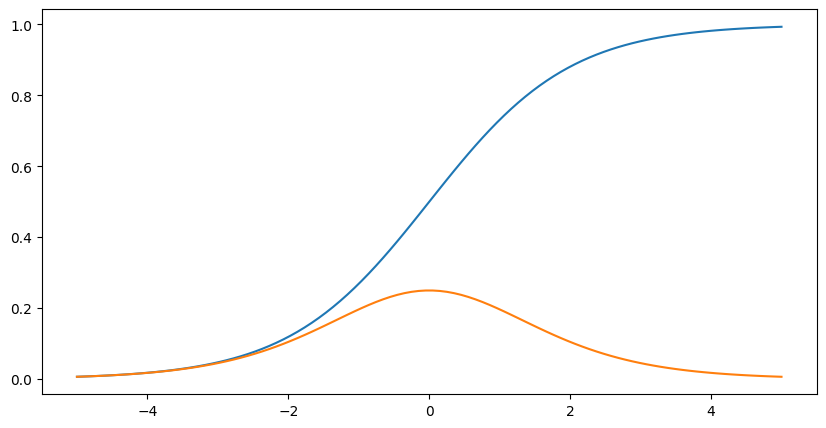

In [13]:
# Your code comes here
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def derivative_sigmoid(x):
  return np.exp(-x) / (1+np.exp(-x))**2

x = np.linspace(-5, 5, 100)
y = sigmoid(x)
y_prime = derivative_sigmoid(x)

plt.plot(x,y)
plt.plot(x,y_prime)

## Training data

Next, load the data in the provided data file "*data-2class.npz*", and plot it. Then also plot the discriminant of a logistic regression model with parameters $\w = [ 0,1,1]$ (where the first element of the vector is $w_0$, the bias of the classification)


The discriminant is where the classifier switches from one class to the other. That is, in this case, the line where the probability of both classes is the same: $p(\class=0|\x) = p(\class=1|\x)$. Since $p(\class=0|\x) = 1-p(\class=1|\x)$, we get $p(\class=0|\x)=p(\c=1|\x)=1/2$. So, to plot the discriminant, we set $$p(\c|\x)=\frac{1}{1+e^{-\w^\top\x}} = 1/2,$$
or $\exp (\w^\top \x) = 1$ or $\w^\top\x = 0$. In other words, we can plot 
$w_0+w_1x_1 + w_2x_2 = 0$, or $x_1 = -\frac{w_2x_2+w_0}{w_1}$


Two-class artificial dataset

This dataset contains 2D datapoints and corresponding labels. The file contains four 
variables:
    explanation: this text, describing how to use the file
    d:           a matrix where each row is a datapoint
    l:           a vector with as many elements as there are rows in d; containing the labels
    v:           a matrix containing l as first column, and d as second and third column


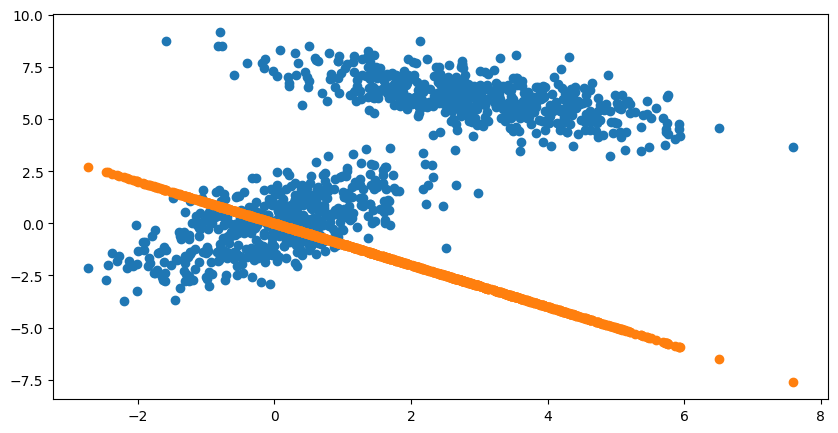

In [34]:
data = np.load("data/data-2class.npz")
d = data['d']
l = data['l']
print(data['explanation'])

# Your code comes here
discriminant = -(d[:, 0] * 1 + 0) / 1

plt.scatter(d[:, 0], d[:, 1])
plt.scatter(d[:,0], discriminant)


## Probability of the given labels for all datapoints

We will now train our logistic regression model on a training dataset. This dataset contains a number of datapoints $\x_1,\dots,\x_N$belonging to two classes and, for each datapoint $\x_n$, the corresponding class label $c_n$. The training is done by *maximum likelihood*, that is, we maximise the probability of the data given the model. 

## Model

Before we start coding, let's have a closer look at the model. Our labels are $0$ or $1$, representing the two classes. If a datapoint $\x_n$ belongs to class $\c_n=1$, the probability $p(\c_n=1|\x_n) = \sigma(\w^\top\x_n)$; otherwise, the probability $p(\c_n=0|\x_n) = 1-\sigma(\w^\top\x)$ (where $\x$ denotes a datapoint which is extended with a constant $1$ as the first dimension, so that the inner product includes the bias $w_0$). We now want the probability of the labels given the data, for the complete training set: $p(\c_1,\dots,\c_N|\x_1,\dots,\x_N)$. Remember that the probability of the union of two independent events is $p(a,b)=p(a)\,p(b)$. Using the fact that the labels are $0$ and $1$ (and that $x^0=1$ and $x^1=x$, we can then write this as 
$$p(\c_1\dots\c_n|\x_1\dots\x_n,\w) = \prod_{n=1}^N \sigma(\w^\top\x_n)^{\c_n}\,(1-\sigma(\w^\top\x_n))^{1-\c_n}$$

**Question 1:** For the provided dataset, compute this probability when the model weights are $\w = [ 0,-1,-1]$. Is the computed answer what you expected? Is it exactly correct?
Think about how an algorithm could find the maximum of this function. What does the gradient of this probability look like (that is, if I changed the value of $\w$ a little bit, how would the probability change)?

In [45]:

# Your code comes here
w = np.array([-1, -1])
activations = sigmoid(d[:].dot(w))
union_of_events = np.power(activations, l) * np.power(1-activations, 1-l)
result = np.prod(union_of_events)

print(f"probability is = {result}")

probability is = 0.0


Dealing with the joint probability is complicated, as 1) its value can become very small, easily too small for a computer to represent it accurately, and 2) taking the gradient of this joint probability with respect to $\w$ makes the contribution of every datapoint to the gradient depend on every other datapoint's value.

# Gradient

So instead, we will define an error function which is the natural logarithm of the likelihood.

**Question 2:** Write down the equation for the error function $E(\w)$ as a function of the parameters, which is defined [$\triangleq$: "equals, by definition"] as $E(\w) \triangleq -\log p(\c_1,\dots,\c_N|\x_1,\dots,\x_N,\w)$, the logarithm of the probability of all the labels given all the datapoints, in analytical form. The basis of the logarithm doesn't matter, so for convenience the natural logarithm is used. 

Remember that the datapoints are assumed to be independent and identically distributed (i.i.d.), so that the probability of one label given the corresponding datapoint is independent of the rest of the data. Simplify this equation as much as possible, so as to make its computation as efficient as possible, and its gradient convenient to derive.



**Answer to Question 2**

\begin{align}
E(\w)
&= -\log \prod_{n=1}^N \sigma(\w^\top\x_n)^{\c_n}\,(1-\sigma(\w^\top\x_n))^{1-\c_n}\\
&= \dots\end{align}




**Question 3:** Compute the actual value of the error function for the given dataset and weight $w=[0,-1,-1]$.

Notice that this function does not contain products of probabilities anymore, but sums of log-probabilities, thus making the derivative of the joint log-probability with respect of each of the weights a sum of derivatives of the log-probabilities of single datapoints. The logarithm is what's called a "monotonically increasing function", which means that if $x_1 > x_2$ then $f(x_1) > f(x_2)$. Because of that, the value of $\w$ for which $p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal is also the value of $\w$ for which $\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal and thus $-\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is minimal.

The gradient of $\nabla_\w E(\w)$ is given by $\nabla_\w E(\w) = \sum_{n=1}^N \left(\sigma( \w^\top\x_n)-c_n\right)\x_n$. You can verify for yourself that that is the case; it is a good exercise and will confirm that your answer to question 2 was correct ;-).



In [29]:

def error(w,v,l):
    pass
print (error(w,v,l))



5056.861918563063


**Question 4** Implement gradient descent, updating the weights as $\w^{\mathrm{new}} = \w^{\mathrm{old}} - \eta \nabla_\w E(\w)$. The value of $\eta$ will affect how fast the algorithm converges and is really up to you. In this case, I suggest you use $\eta=10^{-3}$, which is quite small but allows you to see what's happening. This is a form of batch gradient descent.

Protip: use the "plotheat" function defined above to plot what the classifier looks like at each iteration. This will allow you to visualise how the optimisation is doing.

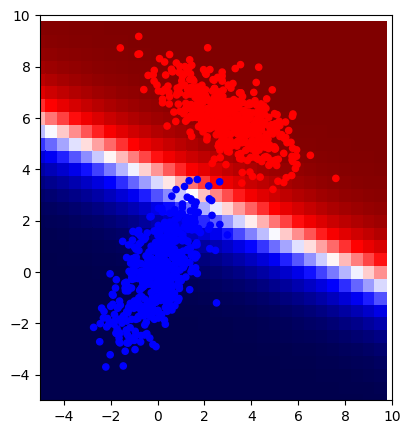

42.44806035525463 42.74324917845381
42.15817032075665 42.44806035525463
41.87342890109358 42.15817032075665
41.59369169625174 41.87342890109358
41.318819800755335 41.59369169625174
41.04867954060109 41.318819800755335
40.78314222534125 41.04867954060109
40.52208391429466 40.78314222534125
40.26538519594823 40.52208391429466


0.001

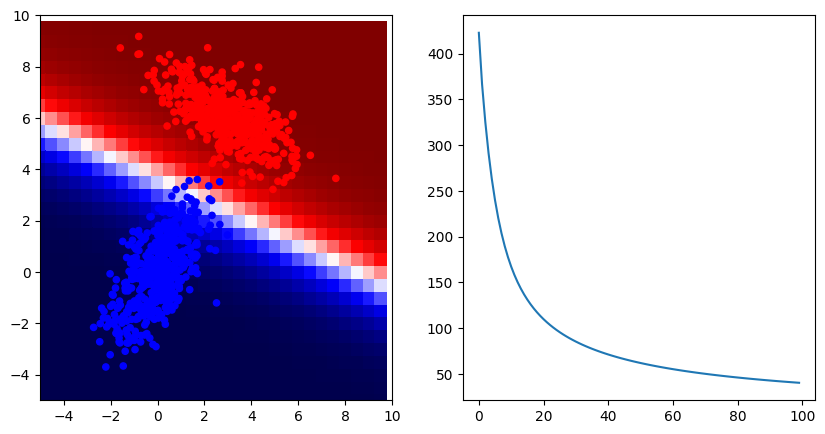

In [30]:
# Your code comes here

# Stochastic gradient descent

**Question 5** As a last question, implement stochastic gradient descent and compare it to batch gradient descent.


**BATCH gradient descent**
CPU times: user 14.4 s, sys: 3.88 ms, total: 14.4 s
Wall time: 14.4 s
**Stochastic gradient descent**
CPU times: user 5.72 s, sys: 0 ns, total: 5.72 s
Wall time: 5.72 s


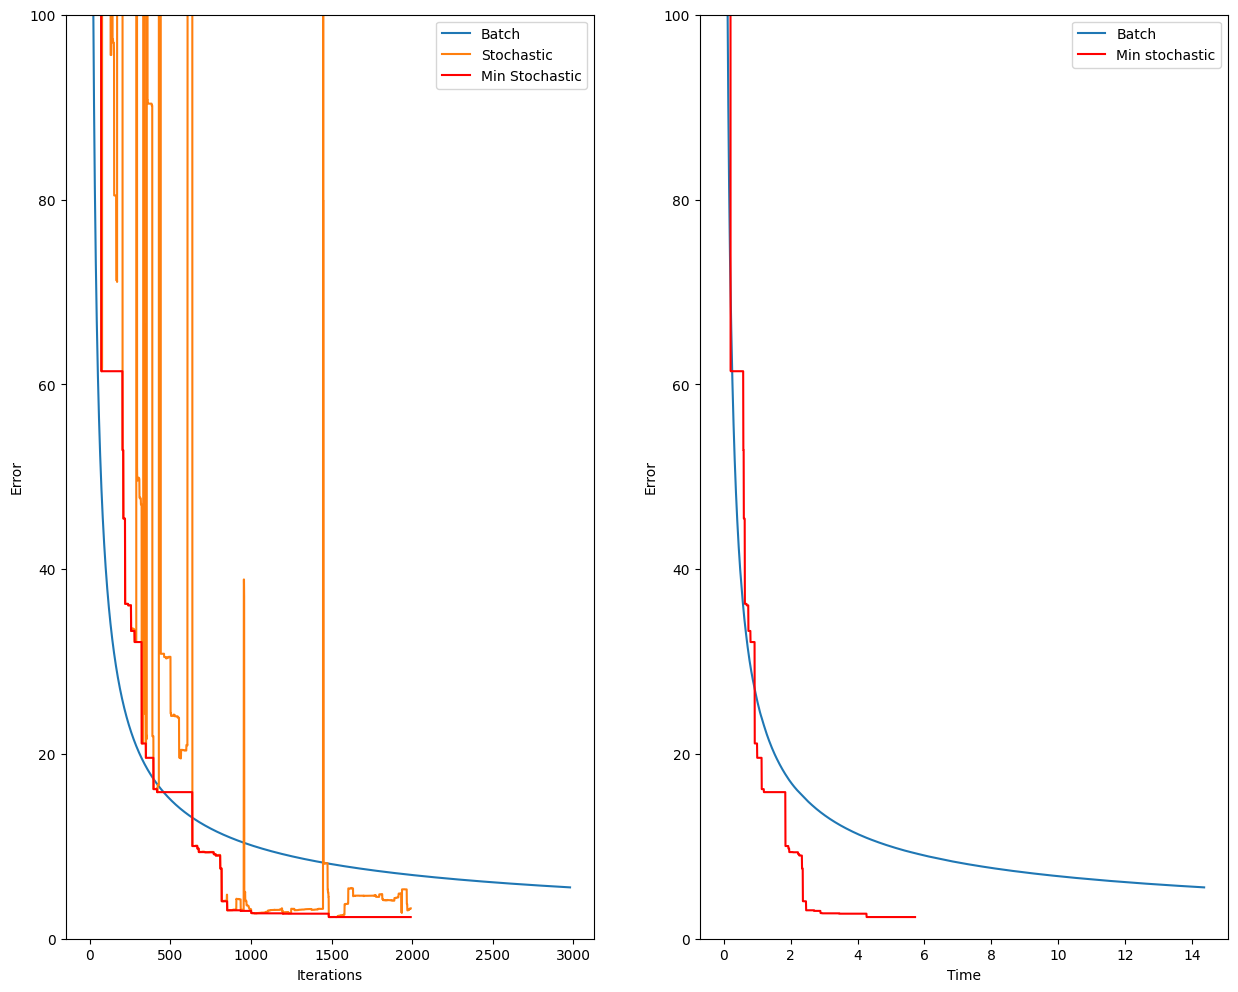

In [32]:
# Your code comes here